# Correlation Analysis for Rideshare vs Taxi trips

## Load and Transform data

### Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset, rownames in column 0
data = pd.read_csv("../../project_data.csv", index_col = 0)

/Users/luciaronchi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Modify columns

In [3]:
# Generate variable to indicate existance of tip in that ride
data["tip_flag"] = data["tip"].apply(lambda x: 1 if x > 0 else 0)

In [4]:
# Change ride_type_id to something more intuitive
data["ride_type"] = data["ride_type_id"].apply(lambda x: "Taxi" if x == 1 else "Rideshare")

In [5]:
# Drop tide_type_id
data.drop(["ride_type_id"], axis = 1, inplace = True)

In [6]:
# Check existing payment types
pay_summary = data.groupby(["payment_type", "ride_type"], as_index = False)["region_pickup"].count()
pay_summary.columns = ["payment_type", "ride_type", "Q"]
pay_summary

,payment_type,ride_type,Q
0,Cash,Taxi,358758
1,Credit Card,Taxi,350370
2,Dispute,Taxi,256
3,Mobile,Taxi,10810
4,No Charge,Taxi,1283
5,Pcard,Taxi,25
6,Prcard,Taxi,6819
7,Prepaid,Taxi,28
8,Unknown,Taxi,5077
9,app,Rideshare,4803318


In [7]:
# Group payment types into more intuitive categories
# Create payment type dictionary
pay_dic = {"Cash": "Cash", "Credit Card": "Card", "Dispute": "Other", "Mobile": "Mobile", "No Charge": "Other",
           "Pcard": "Card", "Prcard": "Card", "Prepaid": "Card", "Unknown": "Other", "app": "Mobile"}
# Convert payment types
data["payment_type"] = data["payment_type"].map(pay_dic)

In [8]:
# Check new payment types
pay_summary = data.groupby(["payment_type", "ride_type"], as_index = False)["region_pickup"].count()
pay_summary.columns = ["payment_type", "ride_type", "Q"]
pay_summary

,payment_type,ride_type,Q
0,Card,Taxi,357242
1,Cash,Taxi,358758
2,Mobile,Rideshare,4803318
3,Mobile,Taxi,10810
4,Other,Taxi,6616


In [9]:
# Drop end times and dates as they can be implied from start time and duration
data.drop(["end_time", "end_date", "end_month", "end_year", "end_weekday"], axis = 1, inplace = True)

In [10]:
# Drop start_year as we are using only 2019
data.drop(["start_year"], axis = 1, inplace = True)

In [11]:
# Drop coordinates
data.drop(["lat_centroid_pickup", "long_centroid_pickup", "lat_centroid_dropoff", "long_centroid_dropoff"], 
          axis = 1, inplace = True)

In [12]:
data.dtypes

duration_seconds               float64
miles                          float64
fare                           float64
tip                            float64
tolls                          float64
extra_charges                  float64
trip_total                     float64
payment_type                    object
start_time                      object
start_date                      object
start_month                      int64
start_weekday                   object
speed_pickup_start             float64
speed_category_pickup_start     object
bus_count_pickup_start         float64
gps_pings_pickup_start         float64
speed_dropoff_end              float64
speed_category_dropoff_end      object
bus_count_dropoff_end          float64
gps_pings_dropoff_end          float64
region_pickup                   object
region_dropoff                  object
tip_flag                         int64
ride_type                       object
dtype: object

### Classify variables into categorical or numerical

In [13]:
cat_vars = ["payment_type", "speed_category_pickup_start", "speed_category_dropoff_end", "region_pickup", 
           "region_dropoff", "tip_flag", "ride_type"]

In [14]:
num_vars = ["duration_seconds", "miles", "fare", "tip", "tolls", "extra_charges", "trip_total", 
            "speed_pickup_start", "bus_count_pickup_start", "gps_pings_pickup_start", "speed_dropoff_end", 
           "bus_count_dropoff_end", "gps_pings_dropoff_end"]

In [15]:
time_vars = ["start_time", "start_date", "start_month", "start_weekday"]

In [16]:
# Check that all columns are accounted for
x = len(data.columns)
for var in data.columns:
    if var in cat_vars or var in num_vars or var in time_vars:
        x = x - 1
if x == 0:
    print("OK")
else:
    print("Not OK")

OK


In [17]:
# Check that there are no extra variables
len(data.columns) == (len(cat_vars) + len(num_vars) + len(time_vars))

True

### Check and correct data types

In [18]:
# Check current data types of categorical variables
data[cat_vars].dtypes

payment_type                   object
speed_category_pickup_start    object
speed_category_dropoff_end     object
region_pickup                  object
region_dropoff                 object
tip_flag                        int64
ride_type                      object
dtype: object

In [19]:
# Convert into type categorial
for var in cat_vars:
    data[var] = data[var].astype('category')

In [20]:
# Check current data types of numerical variables
data[num_vars].dtypes

duration_seconds          float64
miles                     float64
fare                      float64
tip                       float64
tolls                     float64
extra_charges             float64
trip_total                float64
speed_pickup_start        float64
bus_count_pickup_start    float64
gps_pings_pickup_start    float64
speed_dropoff_end         float64
bus_count_dropoff_end     float64
gps_pings_dropoff_end     float64
dtype: object

In [21]:
# Check current data types of time variables
data[time_vars].dtypes

start_time       object
start_date       object
start_month       int64
start_weekday    object
dtype: object

In [22]:
data[time_vars].head

<bound method NDFrame.head of         start_time  start_date  start_month start_weekday
0         13:00:00  2019-05-03            5        Friday
1         11:00:00  2019-01-23            1     Wednesday
2         21:00:00  2019-02-10            2        Sunday
3         18:00:00  2019-07-23            7       Tuesday
4         18:00:00  2019-02-14            2      Thursday
...            ...         ...          ...           ...
5536739   15:00:00  2019-03-24            3        Sunday
5536740   09:00:00  2019-09-18            9     Wednesday
5536741   08:00:00  2019-01-10            1      Thursday
5536742   14:00:00  2019-05-17            5        Friday
5536743   15:00:00  2019-08-24            8      Saturday

[5536744 rows x 4 columns]>

In [23]:
# Convert dates
data["start_date"] = pd.to_datetime(arg = data["start_date"], yearfirst = True, format = "%Y-%m-%d")

In [24]:
# Convert time
data["start_time"] = pd.to_datetime(arg = data["start_time"])

In [25]:
# Convert months and weekdays to categories
data["start_month"] = data["start_month"].astype('category')
data["start_weekday"] = data["start_weekday"].astype('category')

In [26]:
# Check new data types of time variables
data[time_vars].dtypes

start_time       datetime64[ns]
start_date       datetime64[ns]
start_month            category
start_weekday          category
dtype: object

### Final list of variables with correct data types

In [27]:
data.dtypes

duration_seconds                      float64
miles                                 float64
fare                                  float64
tip                                   float64
tolls                                 float64
extra_charges                         float64
trip_total                            float64
payment_type                         category
start_time                     datetime64[ns]
start_date                     datetime64[ns]
start_month                          category
start_weekday                        category
speed_pickup_start                    float64
speed_category_pickup_start          category
bus_count_pickup_start                float64
gps_pings_pickup_start                float64
speed_dropoff_end                     float64
speed_category_dropoff_end           category
bus_count_dropoff_end                 float64
gps_pings_dropoff_end                 float64
region_pickup                        category
region_dropoff                    

## Tipping behaviour

### General Summary

In [28]:
# Summary of tipping behaviour by ride type
tip_summary = data.groupby(["ride_type","tip_flag"], as_index = False)["duration_seconds"].count()
tip_summary.columns = ["ride_type","tip_flag", "Q"]
tip_summary

,ride_type,tip_flag,Q
0,Rideshare,0,3925854
1,Rideshare,1,877464
2,Taxi,0,387285
3,Taxi,1,346141


In [29]:
# percentage of tippers in rideshare
tip_summary.iloc[1,2]/(tip_summary.iloc[0,2] + tip_summary.iloc[1,2])

0.1826787233324964

In [30]:
# percentage of tippers in taxi
tip_summary.iloc[3,2]/(tip_summary.iloc[3,2] + tip_summary.iloc[2,2])

0.471950817124018

Main discovery: Only 18% of rideshare riders tip, vs 47% taxi riders

### Summary by variable

How do all numerical variables correlate?

/Users/luciaronchi/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/luciaronchi/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/luciaronchi/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


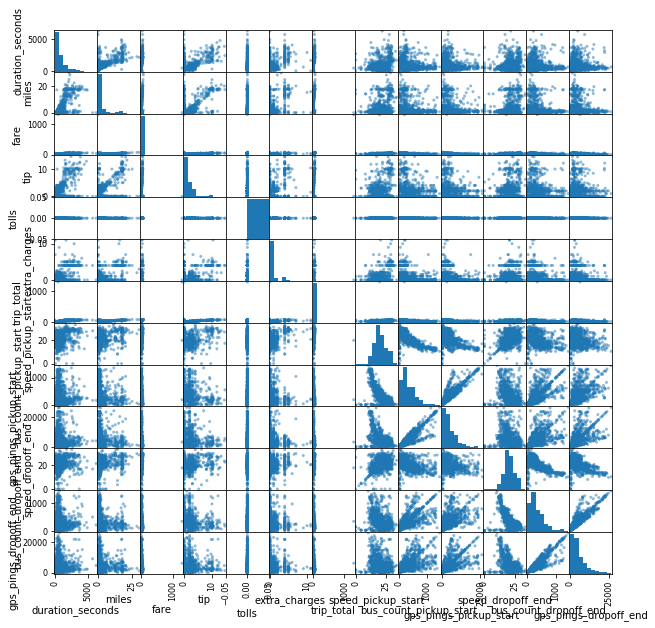

In [31]:
pd.plotting.scatter_matrix(data[num_vars].iloc[0:1000,], figsize = (10,10))
plt.show()

In [32]:
some_num_vars = ["duration_seconds", "miles", "fare", "tip", "speed_pickup_start", "speed_dropoff_end"]

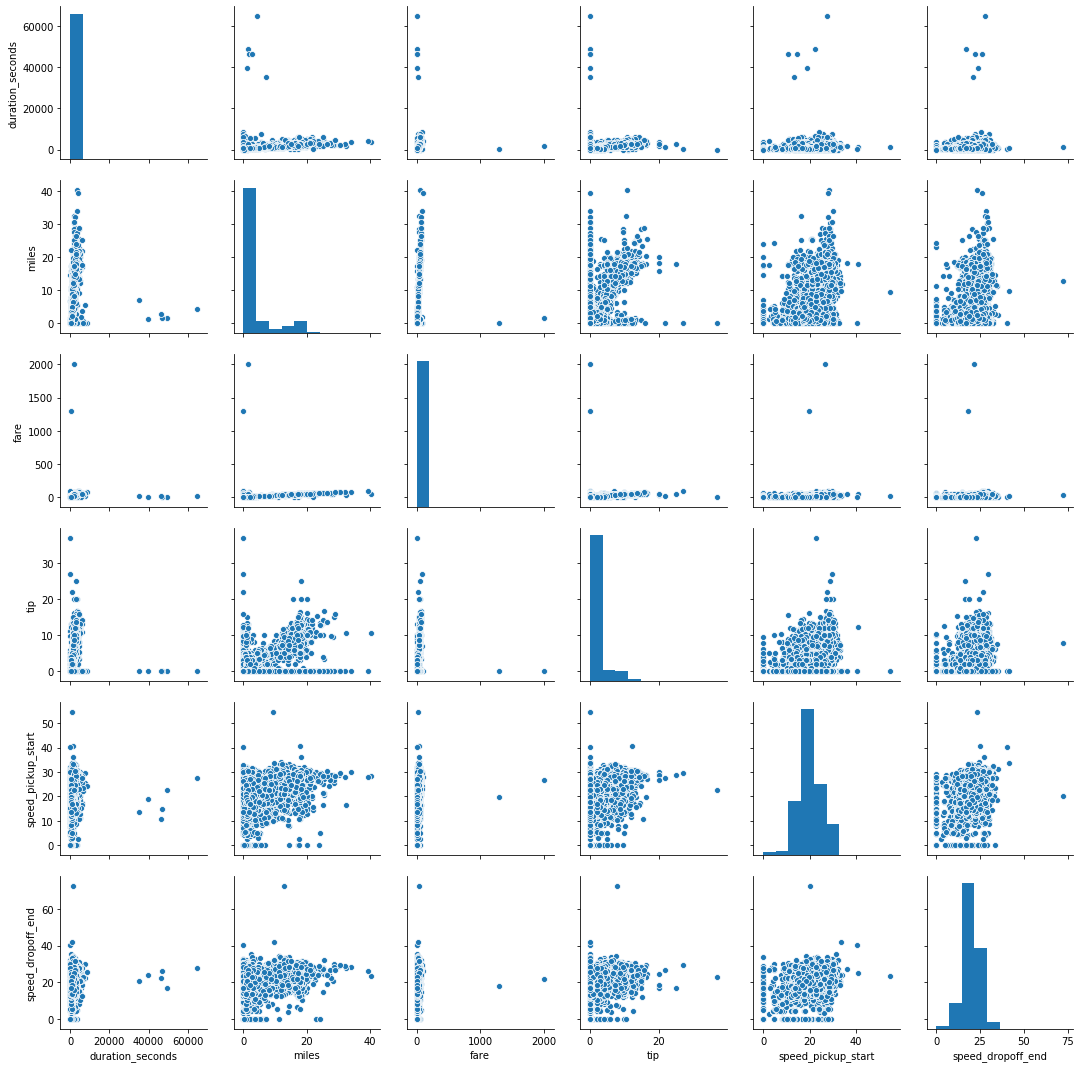

In [33]:
# Basic correlogram
sns.pairplot(data[some_num_vars].iloc[0:10000,])
plt.show()

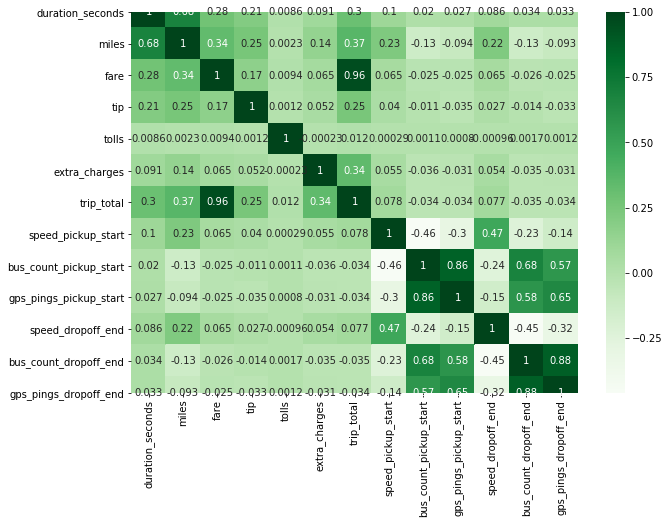

In [34]:
plt.figure(figsize=(10, 7))
sns.heatmap(data.corr(), annot=True, cmap="Greens");

**Findings:**

- Tip PC with duration, miles, fare, and trip total
- Duration PC with miles, fare, and trip total
- Miles PC with duration
- Trip total PC with fare
- Speed pickup NC with bus count and GPS pings
- Speed pickup PC with speed dropoff
- Bus count PC with GPS pings (dropoff and pickup)

## Logistic Regression

Run a logistic regression to predict tip flag based on:

- Duration
- Miles
- Fare
- Ride type
- Payment Type
- Ride type

In [35]:
# Get dummies of categorical variables
dummy_data = pd.get_dummies(data, columns = ["ride_type", "payment_type"])

In [36]:
dummy_data.columns

Index(['duration_seconds', 'miles', 'fare', 'tip', 'tolls', 'extra_charges',
       'trip_total', 'start_time', 'start_date', 'start_month',
       'start_weekday', 'speed_pickup_start', 'speed_category_pickup_start',
       'bus_count_pickup_start', 'gps_pings_pickup_start', 'speed_dropoff_end',
       'speed_category_dropoff_end', 'bus_count_dropoff_end',
       'gps_pings_dropoff_end', 'region_pickup', 'region_dropoff', 'tip_flag',
       'ride_type_Rideshare', 'ride_type_Taxi', 'payment_type_Card',
       'payment_type_Cash', 'payment_type_Mobile', 'payment_type_Other'],
      dtype='object')

In [37]:
# Define x and y
y = dummy_data["tip_flag"]
x = dummy_data[["duration_seconds", "miles", "fare", 'ride_type_Rideshare', 'ride_type_Taxi', 'payment_type_Card',
       'payment_type_Cash', 'payment_type_Mobile', 'payment_type_Other']]

In [38]:
# Store model object
reg = LogisticRegression(random_state = 52173)

In [39]:
# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 52173, test_size = 0.3)

In [40]:
# Fit model on train data set
reg.fit(x_train, y_train)

/Users/luciaronchi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=52173, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# Fitted values
y_pred = reg.predict(x_test)

In [42]:
# Confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1287184    6947]
 [ 265293  101600]]


In [43]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90   1294131
           1       0.94      0.28      0.43    366893

    accuracy                           0.84   1661024
   macro avg       0.88      0.64      0.67   1661024
weighted avg       0.85      0.84      0.80   1661024



Definitions:

- Precision: TP / (TP + FP) >>> TP out of all marked as positives
- Recall: TP / (TP + FN) >>> TP out of all that were positives
- F1: Harmonic mean between precision and recall